# SHAP and Counterfactual Explanations

This notebook is a companion to my blog post ['Explanations for ML Models'](https://medium.com/@steve.p.draper/explanations-for-ml-models-7043303fccd5) and provides the code used to generate
the results presented there.

In this notebook we'll run an explainability analysis using both SHAP an counterfactual explanations and compare
and analyze the results we get from each.

*Note* - this notebook requires at least version `1.2.14` (which is currently pre-release).  It also relies on a
currently beta features (multiple explanations, and alternate explanations), and so requires a beta-enabling flag in the certifai config file.  Ensure that your `~/.certifai/certifai_config.ini` file contains the lines:
```
[scanner]
support_alternate_explanations_beta = true
support_multiple_explanation_types_beta = true
```

In [1]:
from typing import List

import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from ipynb.fs.defs.cat_encoder import CatEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.scanner.explanation_utils import explanations, ExplainedPrediction
from certifai.engine.engine_api_types import ExplanationType

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
all_data_file = f"german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

def build_model(data, name, model_family, test=None):
    np.random.seed(0)
    random.seed(0)
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'probability': [True], 'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model = build_model((encoder(X_train.values), y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'Support Vector Machine' accuracy is 0.77
Model 'Logistic classifier' accuracy is 0.76


In [3]:
# Wrap the models using their soft outputs for Certifai
from sklearn_soft_wrapper import SkLearnSoftWrapper

def _wrap_sklearn_classifier(classifier, encoder=None) -> CertifaiPredictorWrapper:
    return CertifaiPredictorWrapper(SkLearnSoftWrapper(classifier),
                                    soft_predictions=True,
                                    encoder=encoder,
                                    label_ordering=classifier.classes_)

svm_model_proxy = _wrap_sklearn_classifier(svm_model, encoder=encoder)
logistic_model_proxy = _wrap_sklearn_classifier(logistic_model, encoder=encoder)

In [4]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

# Add the explanation dataset - we're only going to bother extracting a small number here
expl_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.dataframe(df[:10]))
scan.add_dataset(expl_dataset)

# Setup an evaluation for fairness on the above dataset using the model
scan.add_evaluation_type('explanation')
scan.evaluation_dataset_id = 'evaluation'
scan.explanation_dataset_id = 'explanation'

# Setup the explanation type. We want to add SHAP to the default 'counterfactual'.
scan.add_explanation_type('shap')
# We also want to generate 3 counterfactuals per example to have some diversity
scan.hyper_parameter_overrides = \
{
    'num_counterfactuals': 3
}

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
result = scan.run(write_reports=False)

2020-05-06 12:59:20,631 root   INFO     Validating license...
2020-05-06 12:59:20,632 root   INFO     License is valid - expires: n/a
2020-05-06 12:59:20,648 root   INFO     Generated unique scan id: 66195ce487e8
2020-05-06 12:59:20,650 root   INFO     Reading configs from: /Users/sdraper/.certifai/certifai_config.ini
2020-05-06 12:59:20,653 root   INFO     Reading default config (fallback) from: /Users/sdraper/miniconda3/envs/notebooks/lib/python3.6/site-packages/certifai/common/utils/default_certifai_config.ini
2020-05-06 12:59:20,656 root   WARNING  Missing config key: 'population' in section: 'algo_hyper_params' - trying default config: /Users/sdraper/miniconda3/envs/notebooks/lib/python3.6/site-packages/certifai/common/utils/default_certifai_config.ini
2020-05-06 12:59:20,657 root   INFO     Read config marker: config['default']['marker'] = 0.1
2020-05-06 12:59:20,658 root   INFO     Validating input data...
2020-05-06 12:59:20,659 root   INFO     Creating dataset with id: evaluat

2020-05-06 12:59:53,314 root   INFO     Normalization constant is 15.390420146798277
2020-05-06 12:59:53,315 root   INFO     Total run time in seconds: 11.986739873886108
2020-05-06 12:59:53,315 root   INFO     Total Samples: 130
2020-05-06 12:59:53,316 root   INFO     Average feature reduction applied to counterfactuals: 0.8
2020-05-06 12:59:53,381 root   INFO     Completed explanation report for model logistic
2020-05-06 12:59:53,388 root   INFO     Completed all evaluations


In [5]:
# Let's look in detail at the explanations for each model of the first data point.
# First extract the explanations in a conveniently consumable form (the `ExplainedPrediction` object model,
# which is part of the Certifai toolkt API)
all_explanations = explanations(result, include_alternates=True)


## Individual Example Explanations

In the cell below we display detailed explanations for the first three examples for each model.  For each
explanation we display:
* The feature importance of the most significant features.  This chart is ordered from most to least important feature, and the coloration depicts whether the influence of that feature is towards the favorable outcome (green) or the unfavorable (red).  On the same chart we plot the features chnaged by the counterfactual explanation in blue
* The SHAP 'force plot' of the same data, again colored according to favorability
* A table of the feature values for the example being explained
* A table of the changes made in th counterfactual explanation

*Note* - if you're viewing this notebook in its pre-run form rather than running it yourself, you'll need to select 'File -> Trust notebook' in the Jupyter menus to view the renderings below.

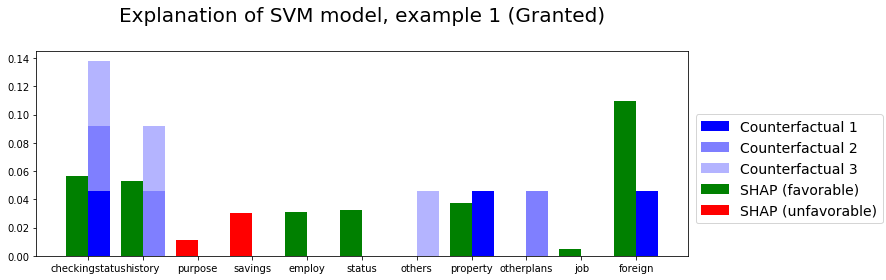

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at leas...,6,critical account/ other credits existing (not ...,car (new),1343,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no


,checkingstatus,history,others,property,otherplans,foreign
Original,... >= 200 DM / salary assignments for at leas...,critical account/ other credits existing (not ...,others - none,real estate,none,foreign - no
Counterfactual 1,... < 0 DM,critical account/ other credits existing (not ...,others - none,unknown / no property,none,foreign - yes
Counterfactual 2,... < 0 DM,all credits at this bank paid back duly,others - none,real estate,bank,foreign - no
Counterfactual 3,... < 0 DM,all credits at this bank paid back duly,co-applicant,real estate,none,foreign - no


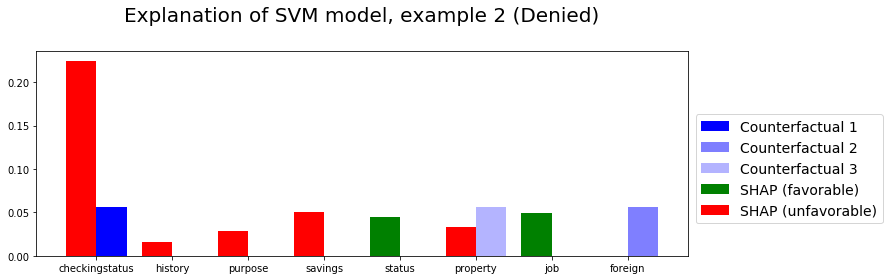

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,28,existing credits paid back duly till now,car (new),4006,... < 100 DM,1 <= ... < 4 years,3,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes


,checkingstatus,property,foreign
Original,... < 0 DM,"car or other, not in attribute 6",foreign - yes
Counterfactual 1,0 <= ... < 200 DM,"car or other, not in attribute 6",foreign - yes
Counterfactual 2,... < 0 DM,"car or other, not in attribute 6",foreign - no
Counterfactual 3,... < 0 DM,real estate,foreign - yes


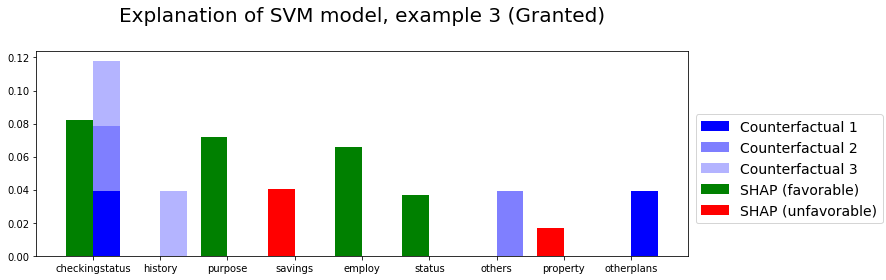

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,2284,... < 100 DM,4 <= ... < 7 years,4,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,others,history,otherplans
Original,no checking account,others - none,existing credits paid back duly till now,none
Counterfactual 1,... < 0 DM,others - none,existing credits paid back duly till now,stores
Counterfactual 2,... < 0 DM,co-applicant,existing credits paid back duly till now,none
Counterfactual 3,... < 0 DM,others - none,all credits at this bank paid back duly,none


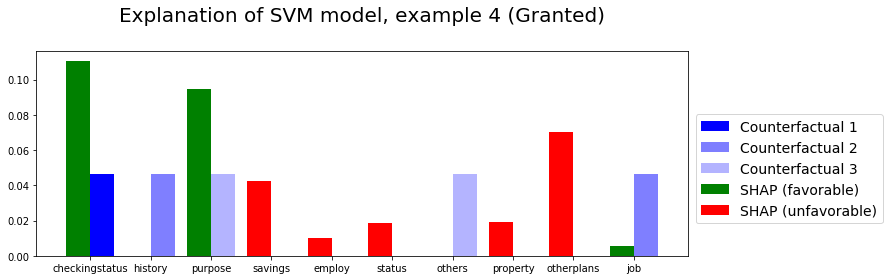

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,1533,... < 100 DM,... < 1 year,4,female : divorced/separated/married,others - none,3,"car or other, not in attribute 6",> 25 years,stores,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,purpose,others,job
Original,no checking account,existing credits paid back duly till now,radio/television,others - none,skilled employee / official
Counterfactual 1,... < 0 DM,existing credits paid back duly till now,radio/television,others - none,skilled employee / official
Counterfactual 2,no checking account,all credits at this bank paid back duly,radio/television,others - none,unemployed/ unskilled - non-resident
Counterfactual 3,no checking account,existing credits paid back duly till now,car (new),co-applicant,skilled employee / official


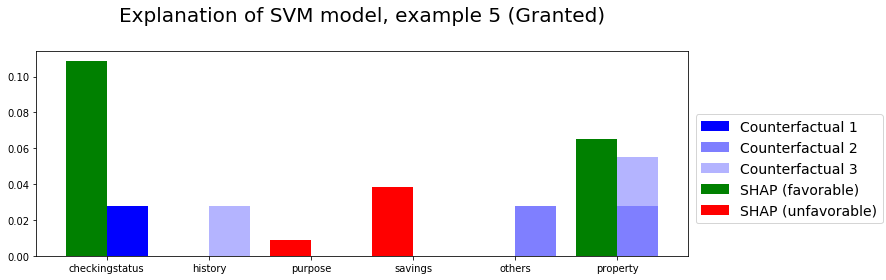

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,12,existing credits paid back duly till now,car (new),1101,... < 100 DM,1 <= ... < 4 years,3,male : married/widowed,others - none,2,real estate,> 25 years,none,own,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,others,history,property
Original,no checking account,others - none,existing credits paid back duly till now,real estate
Counterfactual 1,... < 0 DM,others - none,existing credits paid back duly till now,real estate
Counterfactual 2,no checking account,co-applicant,existing credits paid back duly till now,unknown / no property
Counterfactual 3,no checking account,others - none,all credits at this bank paid back duly,unknown / no property


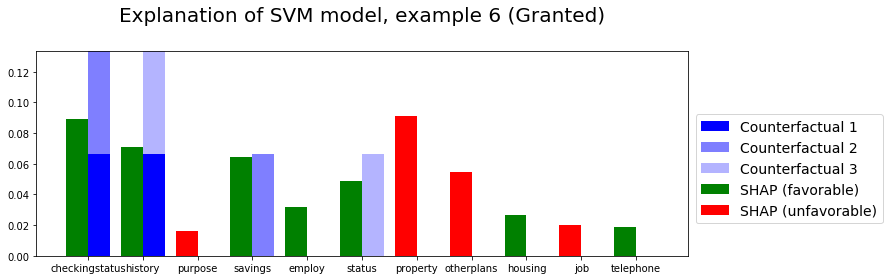

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,60,critical account/ other credits existing (not ...,car (new),13756,unknown/ no savings account,.. >= 7 years,2,male : single,others - none,4,unknown / no property,> 25 years,bank,for free,1,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,status,history,savings
Original,no checking account,male : single,critical account/ other credits existing (not ...,unknown/ no savings account
Counterfactual 1,... < 0 DM,male : single,delay in paying off in the past,unknown/ no savings account
Counterfactual 2,... < 0 DM,male : single,critical account/ other credits existing (not ...,... < 100 DM
Counterfactual 3,no checking account,male : divorced/separated,no credits taken/ all credits paid back duly,unknown/ no savings account


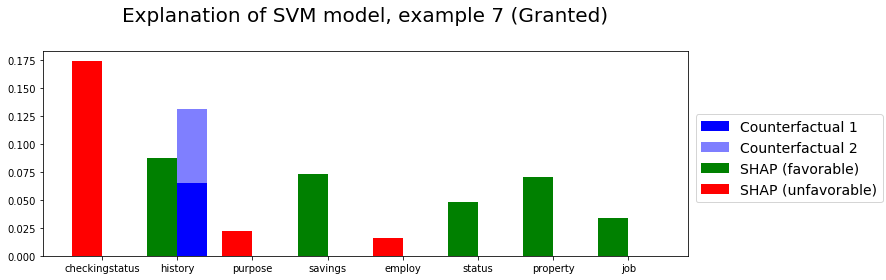

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,6,critical account/ other credits existing (not ...,car (new),4716,unknown/ no savings account,... < 1 year,1,male : single,others - none,3,real estate,> 25 years,none,own,2,unskilled - resident,2,phone - none,foreign - yes


,history
Original,critical account/ other credits existing (not ...
Counterfactual 1,no credits taken/ all credits paid back duly
Counterfactual 2,all credits at this bank paid back duly


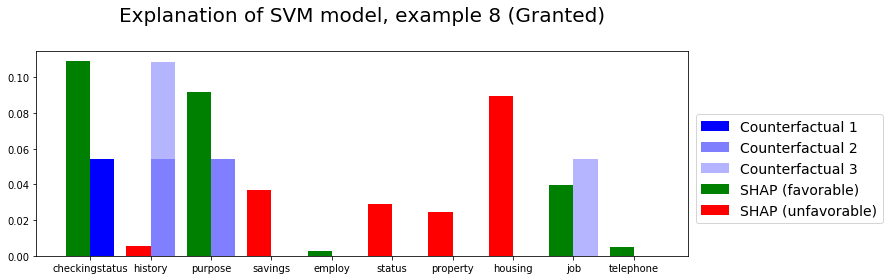

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at leas...,12,existing credits paid back duly till now,radio/television,1881,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,others - none,2,"car or other, not in attribute 6",> 25 years,none,rent,1,unskilled - resident,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,job,history,purpose
Original,... >= 200 DM / salary assignments for at leas...,unskilled - resident,existing credits paid back duly till now,radio/television
Counterfactual 1,... < 0 DM,unskilled - resident,existing credits paid back duly till now,radio/television
Counterfactual 2,... >= 200 DM / salary assignments for at leas...,unskilled - resident,no credits taken/ all credits paid back duly,repairs
Counterfactual 3,... >= 200 DM / salary assignments for at leas...,management/ self-employed/highly qualified emp...,no credits taken/ all credits paid back duly,radio/television


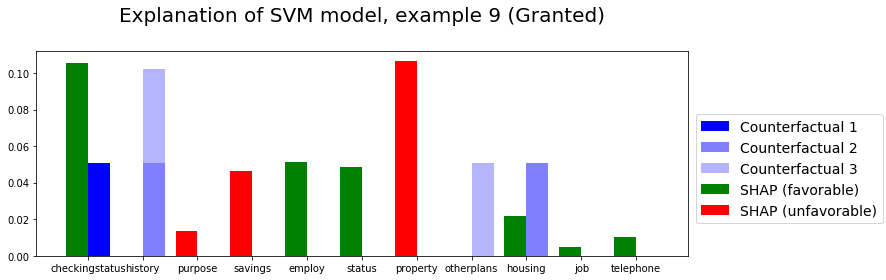

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,delay in paying off in the past,car (new),2032,... < 100 DM,.. >= 7 years,4,male : single,others - none,4,unknown / no property,> 25 years,none,for free,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,otherplans,housing
Original,no checking account,delay in paying off in the past,none,for free
Counterfactual 1,... < 0 DM,delay in paying off in the past,none,for free
Counterfactual 2,no checking account,no credits taken/ all credits paid back duly,none,rent
Counterfactual 3,no checking account,all credits at this bank paid back duly,bank,for free


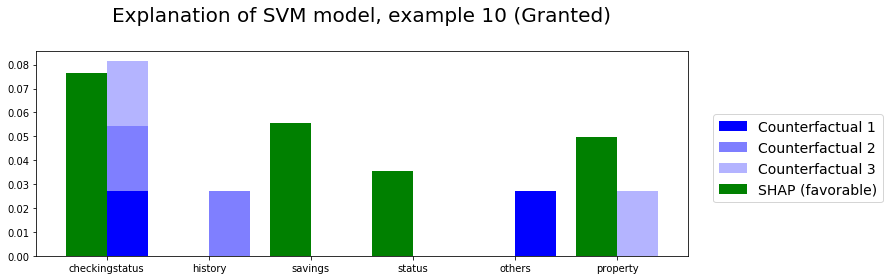

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,36,existing credits paid back duly till now,car (new),3079,unknown/ no savings account,1 <= ... < 4 years,4,male : single,others - none,4,real estate,> 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes


,checkingstatus,others,history,property
Original,no checking account,others - none,existing credits paid back duly till now,real estate
Counterfactual 1,... < 0 DM,co-applicant,existing credits paid back duly till now,real estate
Counterfactual 2,... < 0 DM,others - none,all credits at this bank paid back duly,real estate
Counterfactual 3,... < 0 DM,others - none,existing credits paid back duly till now,unknown / no property


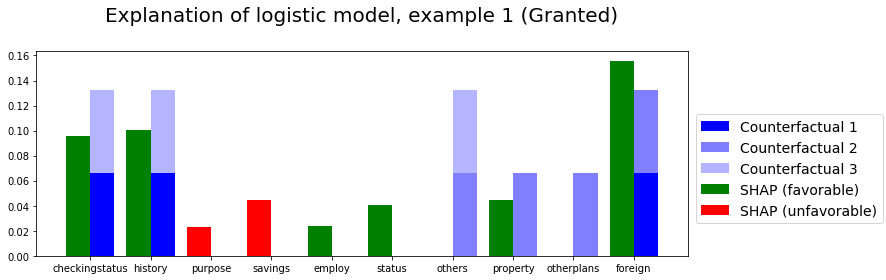

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at leas...,6,critical account/ other credits existing (not ...,car (new),1343,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no


,checkingstatus,history,others,property,otherplans,foreign
Original,... >= 200 DM / salary assignments for at leas...,critical account/ other credits existing (not ...,others - none,real estate,none,foreign - no
Counterfactual 1,... < 0 DM,all credits at this bank paid back duly,others - none,real estate,none,foreign - yes
Counterfactual 2,... >= 200 DM / salary assignments for at leas...,critical account/ other credits existing (not ...,co-applicant,unknown / no property,stores,foreign - yes
Counterfactual 3,... < 0 DM,no credits taken/ all credits paid back duly,co-applicant,real estate,none,foreign - no


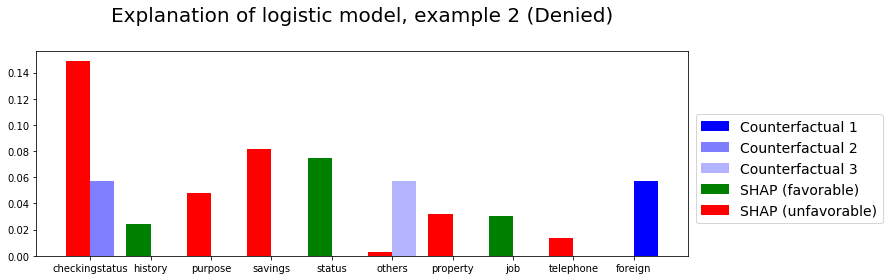

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,28,existing credits paid back duly till now,car (new),4006,... < 100 DM,1 <= ... < 4 years,3,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes


,checkingstatus,others,foreign
Original,... < 0 DM,others - none,foreign - yes
Counterfactual 1,... < 0 DM,others - none,foreign - no
Counterfactual 2,no checking account,others - none,foreign - yes
Counterfactual 3,... < 0 DM,guarantor,foreign - yes


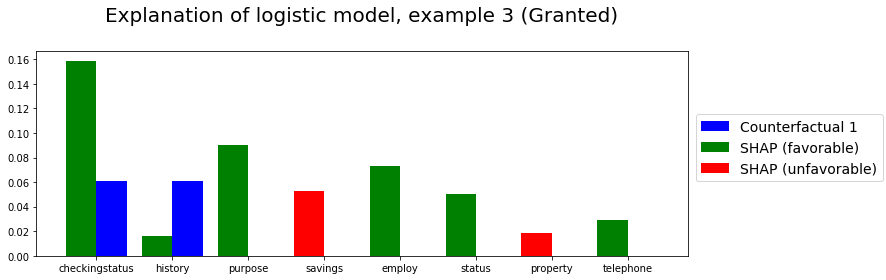

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,2284,... < 100 DM,4 <= ... < 7 years,4,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history
Original,no checking account,existing credits paid back duly till now
Counterfactual 1,... < 0 DM,all credits at this bank paid back duly


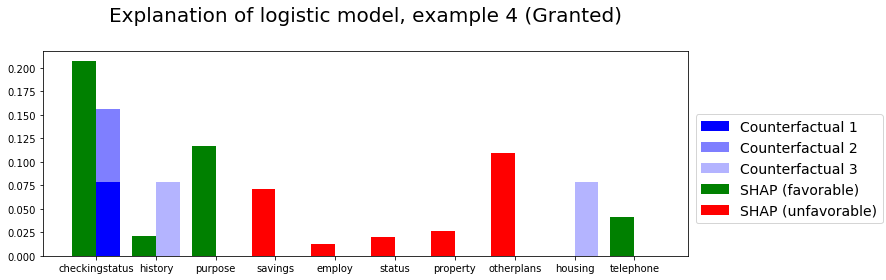

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,1533,... < 100 DM,... < 1 year,4,female : divorced/separated/married,others - none,3,"car or other, not in attribute 6",> 25 years,stores,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,housing
Original,no checking account,existing credits paid back duly till now,own
Counterfactual 1,... < 0 DM,existing credits paid back duly till now,own
Counterfactual 2,0 <= ... < 200 DM,existing credits paid back duly till now,own
Counterfactual 3,no checking account,no credits taken/ all credits paid back duly,rent


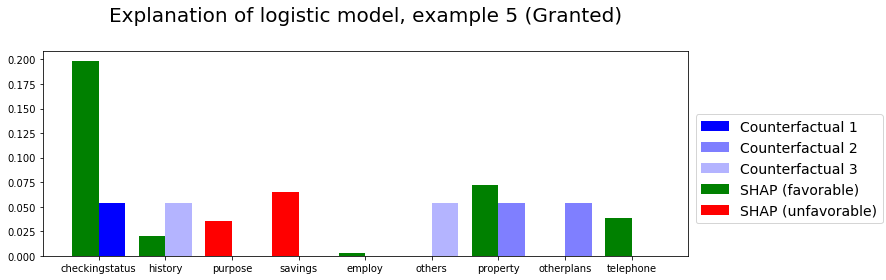

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,12,existing credits paid back duly till now,car (new),1101,... < 100 DM,1 <= ... < 4 years,3,male : married/widowed,others - none,2,real estate,> 25 years,none,own,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,others,property,otherplans
Original,no checking account,existing credits paid back duly till now,others - none,real estate,none
Counterfactual 1,... < 0 DM,existing credits paid back duly till now,others - none,real estate,none
Counterfactual 2,no checking account,existing credits paid back duly till now,others - none,unknown / no property,stores
Counterfactual 3,no checking account,no credits taken/ all credits paid back duly,co-applicant,real estate,none


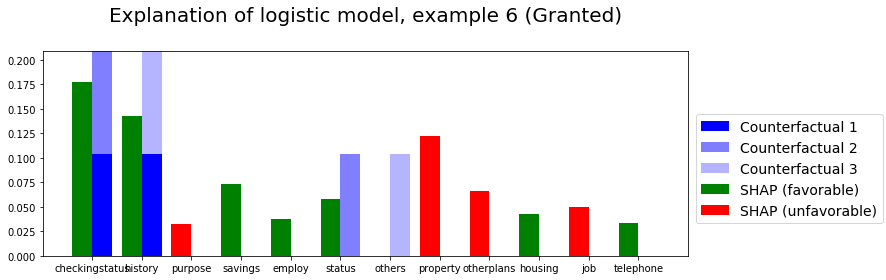

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,60,critical account/ other credits existing (not ...,car (new),13756,unknown/ no savings account,.. >= 7 years,2,male : single,others - none,4,unknown / no property,> 25 years,bank,for free,1,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,status,history,others
Original,no checking account,male : single,critical account/ other credits existing (not ...,others - none
Counterfactual 1,0 <= ... < 200 DM,male : single,delay in paying off in the past,others - none
Counterfactual 2,... < 0 DM,male : married/widowed,critical account/ other credits existing (not ...,others - none
Counterfactual 3,no checking account,male : single,no credits taken/ all credits paid back duly,co-applicant


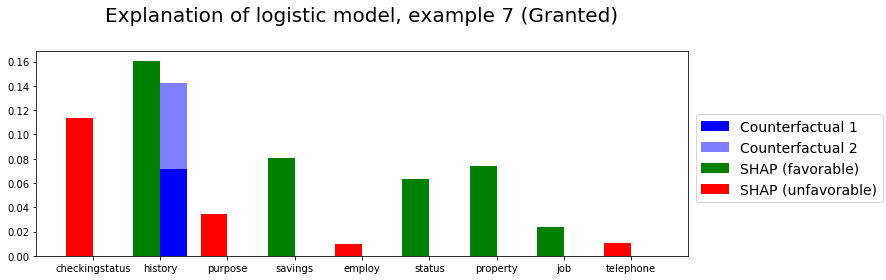

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,6,critical account/ other credits existing (not ...,car (new),4716,unknown/ no savings account,... < 1 year,1,male : single,others - none,3,real estate,> 25 years,none,own,2,unskilled - resident,2,phone - none,foreign - yes


,history
Original,critical account/ other credits existing (not ...
Counterfactual 1,no credits taken/ all credits paid back duly
Counterfactual 2,all credits at this bank paid back duly


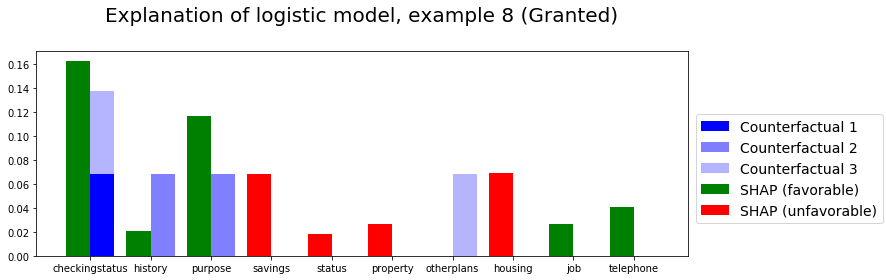

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at leas...,12,existing credits paid back duly till now,radio/television,1881,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,others - none,2,"car or other, not in attribute 6",> 25 years,none,rent,1,unskilled - resident,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,purpose,otherplans
Original,... >= 200 DM / salary assignments for at leas...,existing credits paid back duly till now,radio/television,none
Counterfactual 1,... < 0 DM,existing credits paid back duly till now,radio/television,none
Counterfactual 2,... >= 200 DM / salary assignments for at leas...,all credits at this bank paid back duly,repairs,none
Counterfactual 3,0 <= ... < 200 DM,existing credits paid back duly till now,radio/television,stores


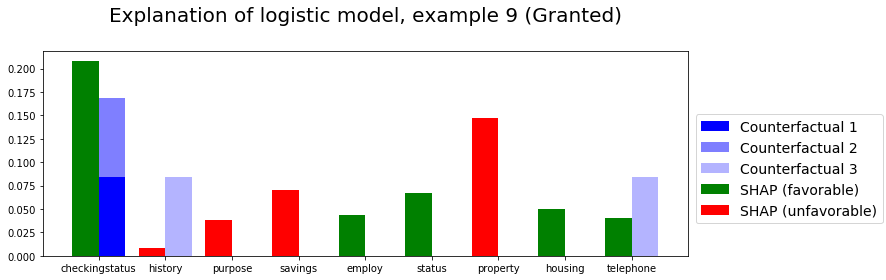

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,delay in paying off in the past,car (new),2032,... < 100 DM,.. >= 7 years,4,male : single,others - none,4,unknown / no property,> 25 years,none,for free,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,telephone
Original,no checking account,delay in paying off in the past,"phone - yes, registered under the customers name"
Counterfactual 1,0 <= ... < 200 DM,delay in paying off in the past,"phone - yes, registered under the customers name"
Counterfactual 2,... < 0 DM,delay in paying off in the past,"phone - yes, registered under the customers name"
Counterfactual 3,no checking account,all credits at this bank paid back duly,phone - none


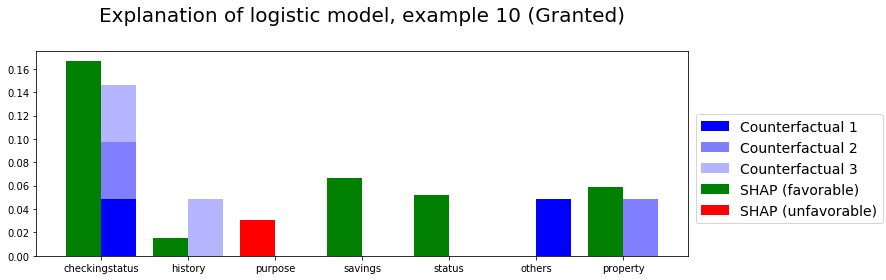

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,36,existing credits paid back duly till now,car (new),3079,unknown/ no savings account,1 <= ... < 4 years,4,male : single,others - none,4,real estate,> 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes


,checkingstatus,others,history,property
Original,no checking account,others - none,existing credits paid back duly till now,real estate
Counterfactual 1,... < 0 DM,co-applicant,existing credits paid back duly till now,real estate
Counterfactual 2,... < 0 DM,others - none,existing credits paid back duly till now,unknown / no property
Counterfactual 3,... < 0 DM,others - none,no credits taken/ all credits paid back duly,real estate


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display, HTML
import shap
import math

shap.initjs()

# Display a SHAP force plot for one example
def display_force_plot(example, is_favorable):
    shap_explanation = example.explanation
    display(shap.force_plot(shap_explanation.class_expected_score,
                            shap_explanation.feature_weights,
                            example.instance,
                            plot_cmap = ["#008000", "#FF0000"] if is_favorable else ["#FF0000", "#008000"]))

# Method to display a table of the field values being explained and a histogram of the SHAP feature weights
# for a given example (displaying contributors towards the favorable outcome in green and those towards
# the unfavorable in red)
def display_explanations(example: List[ExplainedPrediction],
                         title: str,
                         is_favorable: bool):
    np_field_names = np.array(example[0].field_names)
    example_as_pandas = pd.DataFrame(np.expand_dims(example[0].instance, axis=0),
                                     columns=np_field_names)
    
    colors = np.array(['red', 'green'] if is_favorable else ['green', 'red'])
    fig, ax = plt.subplots(figsize=[12,4])
    ax.set_title(title, fontsize=20, pad=30)
    impactful_features = []
    all_cf_impactful_features = []
    shap_ex = None
    cf_changes = []
    cf_idx = 0
    shap_scale = 1.  # default for case with no SHAP
    for ex in example:
        if ex.explanation_type == ExplanationType.SHAP:
            shap_ex = ex
            shap_impactful_features = np.where(ex.explanation.feature_weights != 0.)[0]
            impactful_features.extend(shap_impactful_features.tolist())
            shap_scale = np.sum(np.abs(ex.explanation.feature_weights[shap_impactful_features])).item()
        else:
            cf_impactful_features = np.where(ex.explanation.best_individuals[0].data != ex.instance)[0]
            impactful_features.extend(cf_impactful_features.tolist())
            all_cf_impactful_features.extend(cf_impactful_features)
            cf_changes.append(pd.DataFrame(np.expand_dims(ex.explanation.best_individuals[0].data[cf_impactful_features], axis=0),
                                      columns=np_field_names[cf_impactful_features],
                                      index=[f'Counterfactual {cf_idx+1}']))
            cf_idx += 1
    impactful_features = np.array(list(set(impactful_features)))
    all_cf_impactful_features = np.array(list(set(all_cf_impactful_features)))

    if len(cf_changes) > 0:
        cf_changes.insert(0,
                          pd.DataFrame(np.expand_dims(ex.instance[all_cf_impactful_features], axis=0),
                              columns=np_field_names[all_cf_impactful_features],
                              index=['Original']))
        
    cf_idx = 0
    bottoms = np.zeros(impactful_features.shape[0])
    for ex in example:
        if ex.explanation_type == ExplanationType.SHAP:
            favorability_aligned_weights = ex.explanation.feature_weights[impactful_features]
            if not is_favorable:
                favorability_aligned_weights = -favorability_aligned_weights
            favorability = np.where(favorability_aligned_weights > 0)[0]
            favorable = np.arange(len(impactful_features))[favorability]
            unfavorability = np.where(favorability_aligned_weights < 0)[0]
            unfavorable = np.arange(len(impactful_features))[unfavorability]
            if len(favorable) > 0:
                ax.bar(favorable,
                       np.abs(ex.explanation.feature_weights[impactful_features][favorable]),
                       width=0.4,
                       color='green',
                       label="SHAP (favorable)")           
            if len(unfavorable) > 0:
                ax.bar(unfavorable,
                       np.abs(ex.explanation.feature_weights[impactful_features][unfavorable]),
                       width=0.4,
                       color='red',
                       label="SHAP (unfavorable)")
        else:
            color = (0,0,1,1-math.sqrt(cf_idx)/2)
            ax.bar(np.arange(len(impactful_features)) + 0.4,
                   (ex.explanation.best_individuals[0].data != ex.instance).astype('int')[impactful_features]*shap_scale/8,
                   width=0.4,
                   color=color,
                   label=f'Counterfactual {cf_idx+1}',
                   bottom=bottoms)
            bottoms[np.where((ex.explanation.best_individuals[0].data != ex.instance)[impactful_features])] += shap_scale/8
            cf_idx += 1
        ax.set_xticks(np.arange(len(impactful_features)) + 0.2)
        ax.set_xticklabels(np_field_names[impactful_features])
        
    fig.legend(fontsize=14, bbox_to_anchor=(1.03,.6))
    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    
    plt.show()
    
    if shap_ex is not None:
        display_force_plot(shap_ex, is_favorable)
    
    display(HTML(example_as_pandas.to_html(index=False)))
    
    if len(cf_changes) > 0:
        raw_changes = pd.concat(cf_changes, axis=0, sort=True)[np_field_names[all_cf_impactful_features].tolist()]
        display(raw_changes.fillna(raw_changes.iloc[0]))

max_displayed_examples = 10  # Just display the first few here for illustration

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 48em; }</style>"))

all_joint_explanations = {}
for model, examples in all_explanations.items():
    # Join the explanations on their instance data
    joint = {}
    for exp in list(examples):
        key = tuple(exp.instance.tolist()) # tuples are hashable
        joint[key] = joint.get(key, []) + [exp]
        
    all_joint_explanations[model] = []
    for idx, joint_exp in enumerate(list(joint.values())[:max_displayed_examples]):
        all_joint_explanations[model].append(joint_exp)
        granted = joint_exp[0].prediction == 1
        display_explanations(joint_exp,
                             f"Explanation of {model} model, example {idx+1} ({'Granted' if granted else 'Denied'})",
                             is_favorable=granted)

In [7]:

def mask_single_feature(cf_exp, feature):
    result = np.copy(cf_exp.instance)
    result[feature] = cf_exp.explanation.best_individuals[0].data[feature]
    return result

def breakdown_expln(expln):
    instance = expln[0].instance
    
    shap_expln_idx = -1
    cf_expln_idxs = []
    for idx, e in enumerate(expln):
        if e.explanation_type == ExplanationType.SHAP:
            shap_expln_idx = idx
        else:
            cf_expln_idxs.append(idx)
            
    original_prediction = logistic_model_proxy.model.soft_predict(np.expand_dims(instance, axis=0))
    original_label = logistic_model_proxy.model.predict(np.expand_dims(instance, axis=0))
    print(f"Original prediction: {original_prediction} ({original_label})")
    for idx, cf in enumerate(cf_expln_idxs):
        cf_data = np.expand_dims(expln[cf_expln_idxs[idx]].explanation.best_individuals[0].data, axis=0)
        cf_pred = logistic_model_proxy.model.soft_predict(cf_data)
        cf_label = logistic_model_proxy.model.predict(cf_data)

        print("\n")
        print(f"cf prediction {idx+1}: {cf_pred} ({cf_label})")

        cf_features = np.where(expln[cf_expln_idxs[idx]].explanation.best_individuals[0].data != instance)[0]
        print(f"Changed features: {cf_features}")

        for f in cf_features:
            cf_masked = mask_single_feature(expln[cf_expln_idxs[idx]], f)
            cf_masked_prediction = logistic_model_proxy.model.soft_predict(np.expand_dims(cf_masked, axis=0))
            cf_masked_label = logistic_model_proxy.model.predict(np.expand_dims(cf_masked, axis=0))
            print(f"cf prediction (feature {f} only): {cf_masked_prediction} ({cf_masked_label})")

        print(f"SHAP weights for changed features: {[expln[shap_expln_idx].explanation.feature_weights[f] for f in cf_features]}")

breakdown_expln(all_joint_explanations['logistic'][8])

Original prediction: [[0.72485192 0.27514808]] ([1])


cf prediction 1: [[0.42117132 0.57882868]] ([2])
Changed features: [0]
cf prediction (feature 0 only): [[0.42117132 0.57882868]] ([2])
SHAP weights for changed features: [0.20805611868166782]


cf prediction 2: [[0.3409437 0.6590563]] ([2])
Changed features: [0]
cf prediction (feature 0 only): [[0.3409437 0.6590563]] ([2])
SHAP weights for changed features: [0.20805611868166782]


cf prediction 3: [[0.4933892 0.5066108]] ([2])
Changed features: [ 2 18]
cf prediction (feature 2 only): [[0.55759594 0.44240406]] ([1])
cf prediction (feature 18 only): [[0.6705784 0.3294216]] ([1])
SHAP weights for changed features: [-0.008792957625082157, 0.04040729394715076]
